# Document Setup

- Project ID: EMB_ex20
- Researchers: DK
- Current Version: v1.0

See associated protocol for more details.

In [18]:
# Stdlib
import os
import sys
import random
from collections import Counter
from datetime import datetime
from IPython.display import display, Latex

# Scientific computing
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scipy.sparse.linalg import eigsh

# Network science
import networkx as nx

# Data handling and vis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.lines import Line2D

# Project source
sys.path.append("../../src/")
import synthetic
import utils

# Miscellaneous
from tqdm.auto import tqdm

In [19]:
metadata = {
    "PROJECT_ID": "EMB_ex20",
    "RESEARCHERS": "DK",
    "CURRENT_VERSION": "v1.0",
    "DATE": datetime.today().strftime("%Y%m%d")
}
TAG = "{PROJECT_ID}{CURRENT_VERSION}_{RESEARCHERS}_{DATE}".format(**metadata)

# Experiment

## Preface

**Goal**

Utilize logistic regression to reconstruct multiplexes from embedded remnants.

Unlike similar EMB\_ex19, ex20 utilizes LE for the embedding procedure.

**Procedure**

1. [Set-up] Let $G, H$ be the layers of a duplex.
2. [Set-up] Aggregate $G, H$; call it $A$.
3. [Set-up] Observe some partial observations from $A$; call them $\theta_G, \theta_H$.
4. [Set-up] Calculate the remnants; $R_G = A - \theta_H, R_H = A - \theta_G$.
5. [Embedding] Embed $R_G, R_H$; call them $E_G, E_H$.
6. [Reconstruction] Select some edge, $e = (i,j) \in A$.
7. [Reconstruction] Calculate $d_G(e) = d_{E_G}(i, j), d_H(e) = d_{E_H}(i, j)$ and the quotient $d(e) = \frac{d_G(e)}{d_H(e)}$.
8. [Reconstruction] Train a logistic regression model with $\{ d(e)\}$ as predictor.
9. [Reconstruction] Predict originating layer for each edge in the test set, $A - \theta_G - \theta_H$.
10. [Analysis] Analyze reconstructive performance.

**Notes**
The core of the reconstruction from embedded layers is training a logistic model
$\begin{equation}\begin{aligned}
    R(e) &= \frac{1}{1 + e^{-\beta_1(d_G(e) / d_H(e)) - \beta_0}}\\
    &= \frac{1}{1 + e^{-\beta_0}e^{-\beta_1(d_G(e) / d_H(e))}}\\
    &= \frac{1}{1 + e^{-\beta_0}e^{-\beta_1d(e)}}\\
\end{aligned}\end{equation}$

where $d(e)$ is the quotient of $d_G(e), d_H(e)$ where $d_G(e) = d_G(i,j) = \| E_G[i] - E_G[j] \|$ for edge $e = (i,j)$ and likewise for $d_H(e)$.



## Prerequisite code

In [20]:
def get_representation(remnant, parameters):
    # Book-keeping
    ## Indexing objects
    _nodes = sorted(remnant.nodes())  # * Force networkx indexing
    _nodes_reindexing = {node: idx for idx, node in enumerate(_nodes)}  # Allow for non-contiguous node indices

    ## Hyperparams
    dimension = np.array(parameters["dimension"])
    maxiter = len(_nodes)*parameters["maxiter_multiplier"]
    if parameters["tol_exp"] >= 0:
        tol = 0
    else:
        tol = 10**parameters["tol_exp"]
    # Calculate normalized Laplacian
    L_normalized = nx.normalized_laplacian_matrix(remnant, nodelist=_nodes)

    # Account for first eigenvalue correlated with degrees
    dimension += 1
    # Account for algebraic multiplicity of trivial eigenvalues equal to number of connected components
    num_components = nx.number_connected_components(remnant)

    dimension += num_components
    # Calculate eigenspectra
    eigenvalues, eigenvectors = eigsh(
            L_normalized, k=dimension,
            which="SM", maxiter=maxiter, tol=tol,
        )

    # * Ensure algebraic multiplcity of trivial eigenvalue matches num_components
    # TODO: Fix calculation
    # for idx, w_ in enumerate(w):
    #     trivial_ = sum([np.isclose(val, 0) for val in w_])
    #     components_ = num_components[idx]
    #     if trivial_ != components_:
    #         raise ValueError(
    #             f"""Number of components and algebraic multiplicity
    #             of trivial eigenvalue do not match in remnant layer {idx}
    #             Found {components_} components, {trivial_} near-0 eigenvalues
    #             {w_}
    #             """
    #             )
    # Retrieve eigenvectors and first non-trivial dimension-many components
    eigenvectors = np.array([
            vector[-parameters["dimension"]:]
            for vector in eigenvectors
        ])

    indexed_eigenvectors = {node: eigenvectors[idx] for idx, node in enumerate(_nodes)}

    return indexed_eigenvectors

In [21]:
def calculate_distances(edge, E_G, E_H):
    # Retrieve nodes incident to edge
    i, j = edge

    # Calculate distance between incident nodes in both embeddings
    d_G = np.linalg.norm(E_G[i] - E_G[j])
    d_H = np.linalg.norm(E_H[i] - E_H[j])

    return d_G, d_H

In [22]:
def calculate_distance_ratio(edge, E_G, E_H):
    d_G, d_H = calculate_distances(edge, E_G, E_H)
    if d_H == 0 or d_G == 0:
        return 1
    else:
        return d_G / d_H

## Workflow

In [23]:
# * Experiment Parameters
# >>> LE embedding <<<
params = {
    "dimension": 40,
    "maxiter_multiplier": 100,
    "tol_exp": -8
}

# >>> Logistic regression <<<
penalty = "l2"  # L2 regularization

# >>> Other <<<
repeat = 100  # number of simulations

In [24]:
# * Steps (1) - Get desired duplex
D = utils.read_file("../../data/input/raw/duplex_system=celegans.edgelist")
G, H = utils.duplex_network(D, 1, 3)

### Single run (dev)

In [25]:
# * Steps (2) thru (4) - Observe a priori information and calculate remnants
theta = 0.2
R_G, R_H, testset, trainset = utils.partial_information(G, H, theta)

In [26]:
# * Step (5) - Embed remnants
E_G = get_representation(R_G, params)
E_H = get_representation(R_H, params)

In [27]:
# * Steps (6) and (7) - Calculate distances of nodes incident to edges in both embeddings
distance_ratios_train = np.array([
    np.log(calculate_distance_ratio(edge, E_G, E_H))
    for edge in trainset
]).reshape(-1, 1)
distance_ratios_test = np.array([
    np.log(calculate_distance_ratio(edge, E_G, E_H))
    for edge in testset
]).reshape(-1, 1)

labels_train = list(trainset.values())
labels_test = list(testset.values())

Text(0.5, 1.0, 'Test set distances')

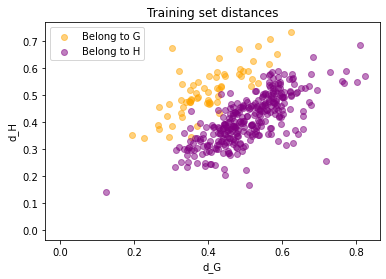

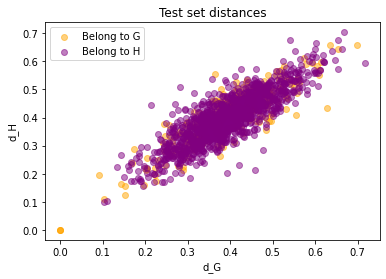

In [28]:
plt.figure()

pts0 = [calculate_distances(edge, E_G, E_H) for edge, class_ in trainset.items() if class_ == 0]
pts1 = [calculate_distances(edge, E_G, E_H) for edge, class_ in trainset.items() if class_ == 1]
plt.scatter([pt[0] for pt in pts1], [pt[1] for pt in pts1], label="Belong to G", color="orange", alpha=0.5)
plt.scatter([pt[0] for pt in pts0], [pt[1] for pt in pts0], label="Belong to H", color="purple", alpha=0.5)

xmax = max(max([p[0] for p in pts0]), max([p[1] for p in pts0]))
xrange = np.arange(0, xmax)
plt.plot(xrange, xrange, linestyle="--", color="darkgray")


plt.legend()

plt.xlabel("d_G")
plt.ylabel("d_H")
plt.title("Training set distances")

# -----

plt.figure()

pts0 = [calculate_distances(edge, E_G, E_H) for edge, class_ in testset.items() if class_ == 0]
pts1 = [calculate_distances(edge, E_G, E_H) for edge, class_ in testset.items() if class_ == 1]
plt.scatter([pt[0] for pt in pts1], [pt[1] for pt in pts1], label="Belong to G", color="orange", alpha=0.5)
plt.scatter([pt[0] for pt in pts0], [pt[1] for pt in pts0], label="Belong to H", color="purple", alpha=0.5)

xmax = max(max([p[0] for p in pts0]), max([p[1] for p in pts0]))
xrange = np.arange(0, xmax)
plt.plot(xrange, xrange, linestyle="--", color="darkgray")

plt.legend()

plt.xlabel("d_G")
plt.ylabel("d_H")
plt.title("Test set distances")

Text(0.5, 1.0, 'Layer origination as a function of distance quotient')

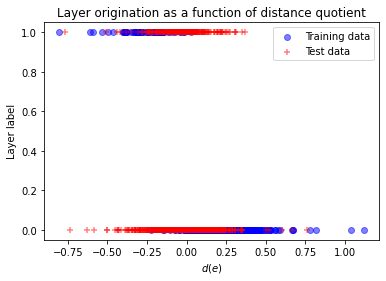

In [29]:
plt.figure()

plt.scatter(distance_ratios_train, labels_train, label="Training data", color="blue", marker="o", alpha=0.5)
plt.scatter(distance_ratios_test, labels_test, label="Test data", color="red", marker="+", alpha=0.5)

plt.legend()

plt.xlabel("$d(e)$")
plt.ylabel("Layer label")
plt.title("Layer origination as a function of distance quotient")

In [30]:
# * Step (8) - Train a logistic regression
model = LogisticRegression(random_state=37, max_iter=10**4)
model.fit(distance_ratios_train, labels_train)

coef = model.coef_
intercept = model.intercept_

Text(0.5, 1.0, 'Layer origination as a function of distance quotient')

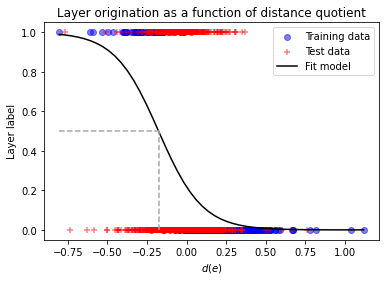

In [31]:
plt.figure()

expit = lambda x: 1 / (1 + np.exp(-x*coef[0] - intercept[0]))
xmin = min(min(distance_ratios_train), min(distance_ratios_test))
xmax = max(max(distance_ratios_train), max(distance_ratios_test))
xrange = np.linspace(xmin, xmax)

plt.scatter(distance_ratios_train, labels_train, label="Training data", color="blue", marker="o", alpha=0.5)
plt.scatter(distance_ratios_test, labels_test, label="Test data", color="red", marker="+", alpha=0.5)

plt.plot(xrange, [expit(x) for x in xrange], label="Fit model", color="black")

model_inv_threshold = -intercept[0]/coef[0]
plt.vlines(model_inv_threshold, 0, 0.5, linestyle="--", color="darkgray")
plt.hlines(0.5, xmin, model_inv_threshold, linestyle="--", color="darkgray")

plt.legend()

plt.xlabel("$d(e)$")
plt.ylabel("Layer label")
plt.title("Layer origination as a function of distance quotient")

In [32]:
# * Step (9) - Predict testset with reconstruction
print(f"Model score: {model.score(distance_ratios_test, labels_test):.4f}")

Model score: 0.7395


In [33]:
model.score(distance_ratios_train, labels_train)

0.949468085106383

### Full experiment

In [34]:
def workflow(G, H, theta):
    # * Steps (2) thru (4) - Observe a priori information and calculate remnants
    R_G, R_H, testset, trainset = utils.partial_information(G, H, theta)

    # * Step (5) - Embed remnants
    E_G = get_representation(R_G, params)
    E_H = get_representation(R_H, params)

    # * Steps (6) and (7) - Calculate distances of nodes incident to edges in both embeddings
    distance_ratios_train = np.array([
        calculate_distance_ratio(edge, E_G, E_H)
        for edge in trainset
    ]).reshape(-1, 1)
    distance_ratios_test = np.array([
        calculate_distance_ratio(edge, E_G, E_H)
        for edge in testset
    ]).reshape(-1, 1)

    labels_train = list(trainset.values())
    labels_test = list(testset.values())

    # * Step (8) - Train a logistic regression
    model = LogisticRegression(random_state=37)
    model.fit(distance_ratios_train, labels_train)

    coef = model.coef_
    intercept = model.intercept_

    # * Step (9) - Predict testset with reconstruction
    score = model.score(distance_ratios_test, labels_test)

## Analysis

### Processing and cleanup

### Visualizations